<a href="https://colab.research.google.com/github/Cyrinegharbi99/CyrineGharbi/blob/master/Moving_avg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
#print("Tensorflow version " + tf.version)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [4]:
#Importing the libraries
import pandas as pd
import numpy as np
from numpy import array 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler 
from sklearn.metrics import mean_squared_error

In [5]:
#Listing the pairs
pairs_list=['EURUSD','USDCAD','USDCHF','USDJPY','AUDUSD','GBPUSD','GBPAUD','GBPCAD','GBPCHF','GBPJPY','GBPNZD','NZDCHF','NZDJPY','NZDUSD','AUDCHF','AUDJPY','AUDNZD','CADCHF','CADJPY','CHFJPY','EURAUD','EURCAD','EURCHF','EURGBP','EURJPY','EURNZD','AUDCAD','NZDCAD']
#Importing the data of all the inpput 3 pairs
for pair in pairs_list :
    globals()["forex_data_" + pair] = pd.read_excel('/content/drive/My Drive/Syrine_folder/' + pair+'.xlsx')
#Calculating the arithmetic perfY for each pair :
for pair in pairs_list:
    df =  globals()["forex_data_" + pair]
    df['perf' + pair] = ( df['close'] - df.shift(1,axis=0)['close'] )/df.shift(1,axis=0)['close']   
#Deleting the rows containing NaN
for pair in pairs_list :
     globals()["forex_data_" + pair] = globals()["forex_data_" + pair].dropna(how = 'any')
#Deleting the dates row :
for pair in pairs_list :
     globals()["forex_data_" + pair].drop('date', axis=1, inplace=True)   
#Normalize the data :
for pair in pairs_list :
    df= globals()["forex_data_" + pair]
    values = df.values
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
#Creating the perf Dataframe containing all the perfY for Y in pairs_list :
perf_df = pd.DataFrame()
for pair in pairs_list:
    perf_df = pd.concat([perf_df, globals()["forex_data_" + pair]["perf" + pair]] , axis =1)
    
perf_df = perf_df.dropna(how = 'any')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
#Importing the data of all the 28 pairs
for pair in pairs_list :
    globals()["forex_test_data_" + pair] = pd.read_excel('/content/drive/My Drive/Syrine_folder/Testing_data/' + pair+'.xlsx')
    
#Calculating the arithmetic perfY for each pair :
for pair in pairs_list:
    df =  globals()["forex_test_data_" + pair]
    df['perf' + pair] = ( df['close'] - df.shift(1,axis=0)['close'] )/df.shift(1,axis=0)['close']
#Deleting the rows containing NaN
for pair in pairs_list :
     globals()["forex_test_data_" + pair] = globals()["forex_test_data_" + pair].dropna(how = 'any')
        
#Deleting the dates row :
for pair in pairs_list :
     globals()["forex_test_data_" + pair].drop('date', axis=1, inplace=True)
        
#Normalize the data :
for pair in pairs_list :
    df= globals()["forex_test_data_" + pair]
    values = df.values
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
#Creating the perf Dataframe containing all the perfY for Y in pairs_list :
perf_test_df = pd.DataFrame()
for pair in pairs_list:
    perf_test_df = pd.concat([perf_df, globals()["forex_test_data_" + pair]["perf" + pair]] , axis =1)
    
perf_test_df = perf_test_df.dropna(how = 'any')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [83]:
timesteps = 18
values = pairs_list 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(perf_df)
scaled_test = scaler.fit_transform(perf_test_df)

reframed = series_to_supervised(scaled, timesteps, 1)
reframed_test = series_to_supervised(scaled, timesteps, 1)
reframed 
n_features = 28
#Preparing the testing and training data
values = reframed.values
test_values = reframed_test.values
print(values.shape)
n_obs = n_features*timesteps
n_train_time = 1868
n_test_time = 1080
train = values[:n_train_time, :]
test = test_values[:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features:]
#When given train_X[0] it should predict train_Y[0]
test_X, test_y = test[:, :n_obs], test[:, -n_features:]

(2377, 532)


**Moving average on 6 timesteps :**

In [84]:
# reshape input to be 3D [samples, timesteps, features] ==> A very key concept in LSTM training
train_X = train_X.reshape((train_X.shape[0], timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], timesteps,n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1868, 18, 28) (1868, 28) (1080, 18, 28) (1080, 28)


In [85]:
train_X[1,:,1]

array([0.58859272, 0.58264559, 0.34943303, 0.5282089 , 0.61916958,
       0.57507104, 0.46670908, 0.31861697, 0.35869137, 0.55770411,
       0.50853628, 0.54002007, 0.41846076, 0.48949636, 0.43987422,
       0.45126061, 0.51124599, 0.49936464])

In [86]:
sum_train=np.zeros((1868,28))
for i in range(1868):
  for j in range(28):
    sum_train[i,j] =np.sum(train_X[i,:,j])/18

In [50]:
sum[1,1]


0.5405201446722577

In [51]:
train_X[1,:,1]

array([0.58859272, 0.58264559, 0.34943303, 0.5282089 , 0.61916958,
       0.57507104])

In [87]:
train_X_avg = sum_train.reshape((sum_train.shape[0],1, n_features))

In [88]:
train_X_avg.shape

(1868, 1, 28)

**Moving average 6 on the testing data**

In [89]:
sum_test=np.zeros((1080,28))
for i in range(1080):
  for j in range(28):
    sum_test[i,j] =np.sum(train_X[i,:,j])/18

In [90]:
test_X_avg = sum_test.reshape((sum_test.shape[0],1, n_features))

In [91]:
test_X_avg.shape

(1080, 1, 28)

In [92]:
#Define model
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (1,28)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 28))

In [93]:
regressor.compile(optimizer='adam', loss='mse')
history = regressor.fit(train_X_avg, train_y, epochs=500, verbose=1,validation_data=(test_X_avg, test_y), shuffle = False) 

Epoch 1/500
59/59 [==============================] - 2s 26ms/step - loss: 0.1292 - val_loss: 0.0072
Epoch 2/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0025
Epoch 3/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0025
Epoch 4/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0027
Epoch 5/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0024
Epoch 6/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 7/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 8/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 9/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 10/500
59/59 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 11

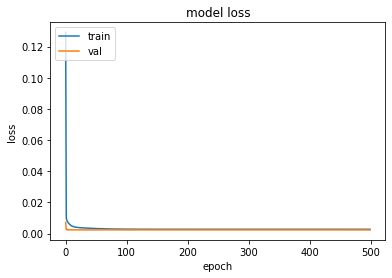

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.ylim(0,1e-2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [96]:
#Forecasting accuracy function 
def calcul_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    accuracy = (np.count_nonzero(np.sign(forecast)== np.sign(actual)) /len(actual))*100 
    smape = 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))
    #return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax, 'accuracy':accuracy})
    return({'rmse':round(rmse,3), 'corr':round(corr,3), 'accuracy':round(accuracy,3), 'mpe': round(mpe,3), 'smape' : round(smape,3)})


In [97]:
prediction = regressor.predict(test_X)
prediction

array([[0.5350816 , 0.49684212, 0.1653746 , ..., 0.54743415, 0.5584118 ,
        0.54497707],
       [0.5369053 , 0.4640954 , 0.16275272, ..., 0.54553133, 0.5559047 ,
        0.54888564],
       [0.5385294 , 0.44206145, 0.16068868, ..., 0.5443558 , 0.55430794,
        0.5519176 ],
       ...,
       [0.53216535, 0.3717468 , 0.16411242, ..., 0.5388602 , 0.5454359 ,
        0.55116916],
       [0.52909565, 0.39410213, 0.16705729, ..., 0.5401387 , 0.54744405,
        0.54634243],
       [0.52760696, 0.41726828, 0.16880825, ..., 0.54178363, 0.54974747,
        0.5434577 ]], dtype=float32)

In [73]:
accuracy=[]
for i in range(1,24) :
    accuracy = [accuracy,calcul_accuracy(test_y[i],prediction[i])]
accuracy

[[[[[[[[[[[[[[[[[[[[[[[[],
                       {'accuracy': 100.0,
                        'corr': 0.726,
                        'mpe': 0.099,
                        'rmse': 0.104,
                        'smape': 13.607}],
                      {'accuracy': 100.0,
                       'corr': 0.789,
                       'mpe': -0.036,
                       'rmse': 0.081,
                       'smape': 14.049}],
                     {'accuracy': 100.0,
                      'corr': 0.777,
                      'mpe': 0.078,
                      'rmse': 0.084,
                      'smape': 13.274}],
                    {'accuracy': 100.0,
                     'corr': 0.893,
                     'mpe': -0.093,
                     'rmse': 0.063,
                     'smape': 11.331}],
                   {'accuracy': 100.0,
                    'corr': 0.871,
                    'mpe': 0.069,
                    'rmse': 0.054,
                    'smape': 7.912}],
            

In [100]:
prediction[2][2],test_y[2][2]

(0.16068868, 0.11065551438051932)